# Extract samples

Import nesessary libraries

In [1]:
import torch
import cv2
import numpy as np
from PIL import Image
import tifffile
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]

Get the tiff image

In [2]:
# Using the with statement to ensure the file is properly closed
original_images = []
with tifffile.TiffFile('/fhome/mapsiv/QuironHelico/WSI_Example/B22-25-HP.tiff') as tif:
    image1 = tif.asarray()
    original_images.append(image1)
with tifffile.TiffFile('/fhome/mapsiv/QuironHelico/WSI_Example/B22-31-HP.tiff') as tif:
    image2 = tif.asarray()
    original_images.append(image2)
with tifffile.TiffFile('/fhome/mapsiv/QuironHelico/WSI_Example/B22-35-HP.tiff') as tif:
    image3 = tif.asarray()
    original_images.append(image3)

**Image preprocessing**

Resize

In [3]:
# Get the shape of the image
resized_images = []
for original_img in original_images:
    new_size = [int(size/10) for size in original_img.shape]

    # Perform resize
    Rimage = cv2.resize(original_img, (new_size[1], new_size[0]))
    resized_images.append(Rimage)

Pass to HSV colorspace

In [4]:
# Change to hsv color space
hsv_images = []
for resized_img in resized_images:
    # Convert RGB to BGR
    bgr_img = cv2.cvtColor(resized_img, cv2.COLOR_RGB2BGR)
    # Convert BGR to HSV
    hsv_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)
    hsv_images.append(hsv_img)

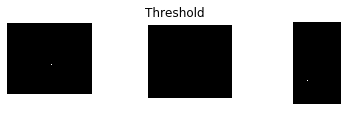

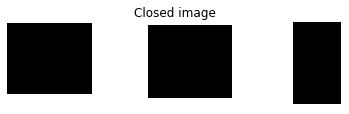

In [5]:
# FOR IMAGE 1
hsv_img = hsv_images[0]

# 1. Extract the Value (brightness) channel
v_channel = hsv_img[:, :, 2]

_,binary_image=cv2.threshold(v_channel, 250, 200, cv2.THRESH_BINARY)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10,10))
opening1 = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

plt.imshow(binary_image, cmap='gray')
plt.title('Threshold')
plt.axis('off')
plt.show()

plt.imshow(opening1, cmap='gray')
plt.title('Closed image')
plt.axis('off')
plt.show()

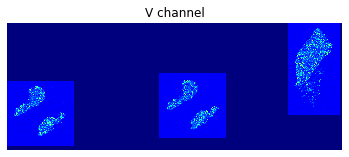

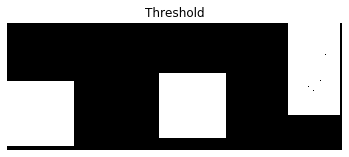

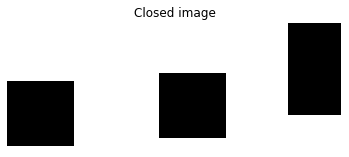

In [6]:
# FOR IMAGE 2
hsv_img = hsv_images[1]

# 1. Extract the Value (brightness) channel
v_channel = hsv_img[:, :, 1]

_,binary_image=cv2.threshold(v_channel, 10, 230, cv2.THRESH_BINARY)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10,10))
opening2 = cv2.morphologyEx(cv2.bitwise_not(binary_image), cv2.MORPH_OPEN, kernel)
# kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT,(50,50))
# opening2 = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel2)

plt.imshow(v_channel, cmap='jet')
plt.title('V channel')
plt.axis('off')
plt.show()

plt.imshow(binary_image, cmap='gray')
plt.title('Threshold')
plt.axis('off')
plt.show()

plt.imshow(opening2, cmap='gray')
plt.title('Closed image')
plt.axis('off')
plt.show()

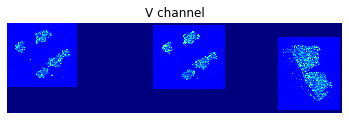

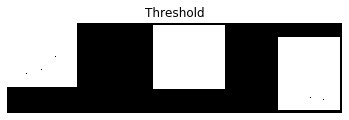

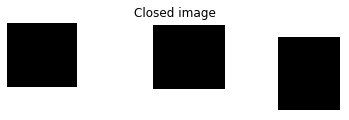

In [7]:
# FOR IMAGE 3
hsv_img = hsv_images[2]

# 1. Extract the Value (brightness) channel
v_channel = hsv_img[:, :, 1]

_,binary_image=cv2.threshold(v_channel, 10, 230, cv2.THRESH_BINARY)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(45,45))
opening3 = cv2.morphologyEx(cv2.bitwise_not(binary_image), cv2.MORPH_OPEN, kernel)

plt.imshow(v_channel, cmap='jet')
plt.title('V channel')
plt.axis('off')
plt.show()

plt.imshow(binary_image, cmap='gray')
plt.title('Threshold')
plt.axis('off')
plt.show()

plt.imshow(opening3, cmap='gray')
plt.title('Closed image')
plt.axis('off')
plt.show()

In [8]:
opened_images = [opening2, opening3]

# Define the padding size
padding_size = 200

padded_images = []
for opened_image in opened_images:
    # Add black padding to the image
    height, width = opened_image.shape[:2]
    padded_image = np.ones((height + 2 * padding_size, width + 2 * padding_size), dtype=np.uint8) * 255
    padded_image[padding_size:padding_size + height, padding_size:padding_size + width] = opened_image
    padded_images.append(padded_image)

In [150]:
FINAL_PATCHES = []
i = 1
for padded_img in padded_images:
    _, thresholded = cv2.threshold(padded_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    x, y = padded_img.shape
    coords = []
    
    for contour in contours:
        if cv2.contourArea(contour) > (0):  # You might want to set a threshold based on the size of squares
            x, y, w, h = cv2.boundingRect(contour)
            coords.append((x - 199, y - 199, x + w - 199, y + h - 199))
    
    print(coords)
    
    images = [resized_images[i][coord[1]:coord[3], coord[0]:coord[2]] for coord in coords]; i += 1
    print(len(images))
    FINAL_PATCHES.append(images)

[(1, 2113, 2439, 4482), (5540, 1824, 7976, 4167), (10239, 1, 12132, 3336)]
3
[(10179, 529, 12517, 3269), (5491, 86, 8200, 2475), (1, 1, 2634, 2389)]
3


In [154]:
print(len(FINAL_PATCHES))

2


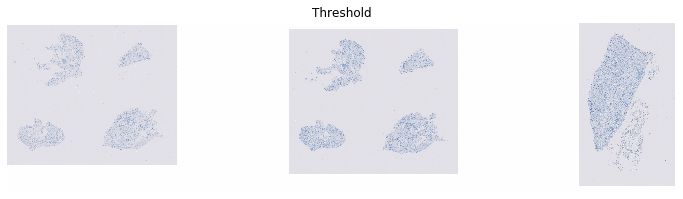

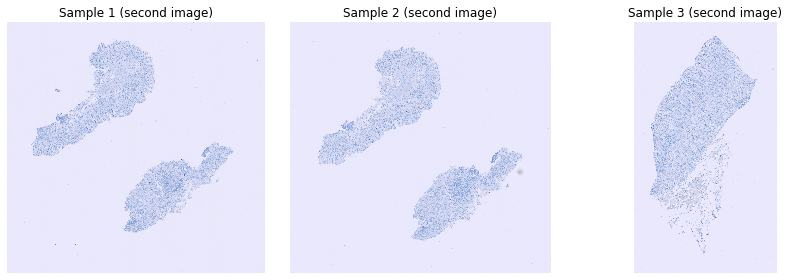

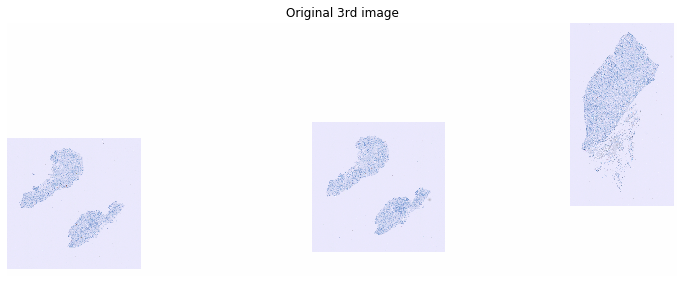

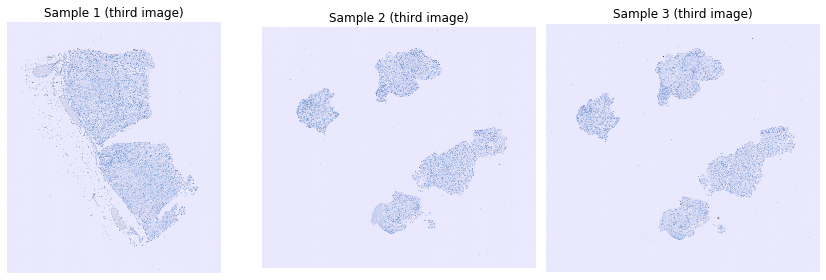

In [161]:
plt.imshow(resized_images[0], cmap='gray')
plt.title('Threshold')
plt.axis('off')
plt.show()

plt.figure(figsize=(12, 4)) 

# First Image
plt.subplot(1, 3, 1) 
plt.imshow(FINAL_PATCHES[0][0])
plt.title('Sample 1 (second image)')
plt.axis('off')

# Second Image
plt.subplot(1, 3, 2)
plt.imshow(FINAL_PATCHES[0][1])
plt.title('Sample 2 (second image)')
plt.axis('off')

# Third Image
plt.subplot(1, 3, 3)
plt.imshow(FINAL_PATCHES[0][2])
plt.title('Sample 3 (second image)')
plt.axis('off')

plt.tight_layout()
plt.show()

################################################

plt.imshow(resized_images[1], cmap='gray')
plt.title('Original 3rd image')
plt.axis('off')
plt.show()

plt.figure(figsize=(12, 4)) 

# First Image
plt.subplot(1, 3, 1) 
plt.imshow(FINAL_PATCHES[1][0])
plt.title('Sample 1 (third image)')
plt.axis('off')

# Second Image
plt.subplot(1, 3, 2)
plt.imshow(FINAL_PATCHES[1][1])
plt.title('Sample 2 (third image)')
plt.axis('off')

# Third Image
plt.subplot(1, 3, 3)
plt.imshow(FINAL_PATCHES[1][2])
plt.title('Sample 3 (third image)')
plt.axis('off')

plt.tight_layout()
plt.show()

In [163]:
cv2.imwrite('samples_patches/patch1_image2.jpg', FINAL_PATCHES[0][0])
cv2.imwrite('samples_patches/patch2_image2.jpg', FINAL_PATCHES[0][1])
cv2.imwrite('samples_patches/patch3_image2.jpg', FINAL_PATCHES[0][2])

cv2.imwrite('samples_patches/patch1_image3.jpg', FINAL_PATCHES[1][0])
cv2.imwrite('samples_patches/patch2_image3.jpg', FINAL_PATCHES[1][1])
cv2.imwrite('samples_patches/patch3_image3.jpg', FINAL_PATCHES[1][2])

True